# Khehla Malakoane
---
Table of Contents <br/>
* [Data Gathering](#DG)
* [Data Exploration](#DE)
* [Data Preparation](#DP)
* [Modeling](#DM)
* [Evaluation](#EV)
* [Results](#RE)

In [1]:
# data processing and storage
import numpy as np
import pandas as pd

# get geographical information from APIs
from geopy.geocoders import Nominatim
import requests

# data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import squarify as sqr

# viz for mapping
import folium

# clustering
from sklearn.cluster import KMeans

%matplotlib inline

# function definition
def getEstablishments(district,
                      latitudes,
                      longitudes, 
                      CLIENT_ID, 
                      CLIENT_SECRET, 
                      VERSION, 
                      radius=1000, 
                      LIMIT=10000):
    venues_list=[]
    for (name, 
         lat, 
         lng) in zip(district, 
                     latitudes, 
                     longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, lat, lng,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 'Lat', 'Lon',
             'Venue_ID','Venue', 'Venue_Lat', 
             'Venue_Lon', 'Venue_Cat']
    print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

def cluster_output(cluster,colors='Reds'):
    cluster_df = manila_clusters[manila_clusters['Cluster']==cluster]
    cluster_venues = pd.DataFrame()
    for district in cluster_df['District']:
        cluster_venues = cluster_venues.append(manila_venues.loc[manila_venues['District']==district])
    cluster_venues.reset_index(drop=True,inplace=True)

    cluster_name = 'Cluster0'
    plt.figure(figsize=(10,6))
    Top20_Venues = cluster_venues['Venue_Cat'].value_counts().head(20)
    Top20_Venues = pd.DataFrame({'Venue':Top20_Venues.index,
                                'Count':Top20_Venues.values
                               })
    sns.barplot(y='Venue',
                x='Count',
                data=Top20_Venues,
                palette=colors+"_r"
               )
    plt.title('Top 20 Establishment Types in Cluster '+str(cluster),fontsize=20)
    plt.show()
    display(cluster_df.drop(['Lon','Lat','Cluster'],axis=1))
    return

def coordsCollector(districts):
    #initialize a geolocator instance
    geolocator = Nominatim(user_agent="geolocator")
    longitude, latitude = [],[]

    #loop to get coordinates per district
    for place in ManilaDistricts:
        location = '{}, Manila, Philippines'.format(place)
        geo = geolocator.geocode(location)
        longitude.append(geo.longitude)
        latitude.append(geo.latitude)

    #compile all results in a dataframe
    df = pd.DataFrame({'District':ManilaDistricts,
                       'Lon':longitude,
                       'Lat':latitude
                      })
    return(df)

## Data Gathering <a id='DG'></a>
---

In [2]:
# district declaration, districts of Manila
ManilaDistricts = ['Binondo','Ermita','Intramuros',
                   'Malate','Paco','Pandacan',
                   'Port Area','Quiapo','Sampaloc',
                   'San Andres','San Miguel','San Nicolas',
                   'Santa Cruz','Santa Mesa','Tondo'
                  ]

df = coordsCollector(ManilaDistricts)
df

,District,Lon,Lat
0,Binondo,120.974707,14.600899
1,Ermita,120.982242,14.579197
2,Intramuros,120.975330,14.590586
3,Malate,120.991529,14.568964
4,Paco,120.993492,14.584574
5,Pandacan,121.008927,14.590479
6,Port Area,120.968612,14.588960
7,Quiapo,120.987364,14.598139
8,Sampaloc,120.996567,14.610265
9,San Andres,120.999547,14.573119


In [3]:
# type your own Credentials here
CLIENT_ID = 'Insert API ID' # your Foursquare ID
CLIENT_SECRET = 'Insert API SECRET' # your Foursquare Secret
VERSION = 'Insert Version' # Foursquare API version

manila_venues = getEstablishments(
                district=df['District'],
                latitudes=df['Lat'],
                longitudes=df['Lon'],
                CLIENT_ID=CLIENT_ID,
                CLIENT_SECRET=CLIENT_SECRET,
                VERSION=VERSION)

print(manila_venues.shape)
manila_venues.tail()

1103 venues were returned by Foursquare.
(1103, 8)


,District,Lat,Lon,Venue_ID,Venue,Venue_Lat,Venue_Lon,Venue_Cat
1098,Tondo,14.618909,120.966039,51cfcf7d498e3b44628c1ab6,D Salas Kainan,14.619946,120.974213,Dessert Shop
1099,Tondo,14.618909,120.966039,4f80f90ce4b024a26dcefc48,Pampanga Market,14.625884,120.970157,Flea Market
1100,Tondo,14.618909,120.966039,565173e8498ee2f56533e8bb,Arkys Lemons Burger,14.626562,120.970135,American Restaurant
1101,Tondo,14.618909,120.966039,4ce602ace888f04ddcda336b,Aling Ning Tapsi,14.626709,120.969838,Restaurant
1102,Tondo,14.618909,120.966039,4f5d42ade4b02628c2c1e86e,Jeanstation,14.610142,120.966790,Clothing Store


## Data Exploration <a id='DE'></a>
---

In [4]:
address = 'Manila, Philippines'
geolocator = Nominatim(user_agent="geolocator")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_manila = folium.Map(location=[latitude, longitude],
                        zoom_start=13)
for (lat,
    lng,
    district,
    venue) in zip(manila_venues['Venue_Lat'],
                 manila_venues['Venue_Lon'],
                 manila_venues['District'],
                 manila_venues['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='gray',
        fill=False,
    ).add_to(map_manila)  
    
for lat, lng, district in zip(df['Lat'],
                              df['Lon'],
                              df['District']):
    label = '{}, Manila'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7
    ).add_to(map_manila)  
map_manila

Text(0.5, 1.0, 'Number of Establishments (Retrieved) per District')

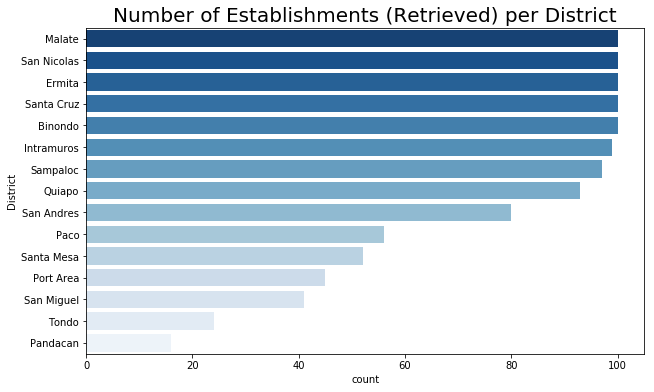

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(y="District",
              data=manila_venues,
              order = manila_venues['District'].value_counts().index,
              palette="Blues_r"
             )
plt.title('Number of Establishments (Retrieved) per District',fontsize=20)

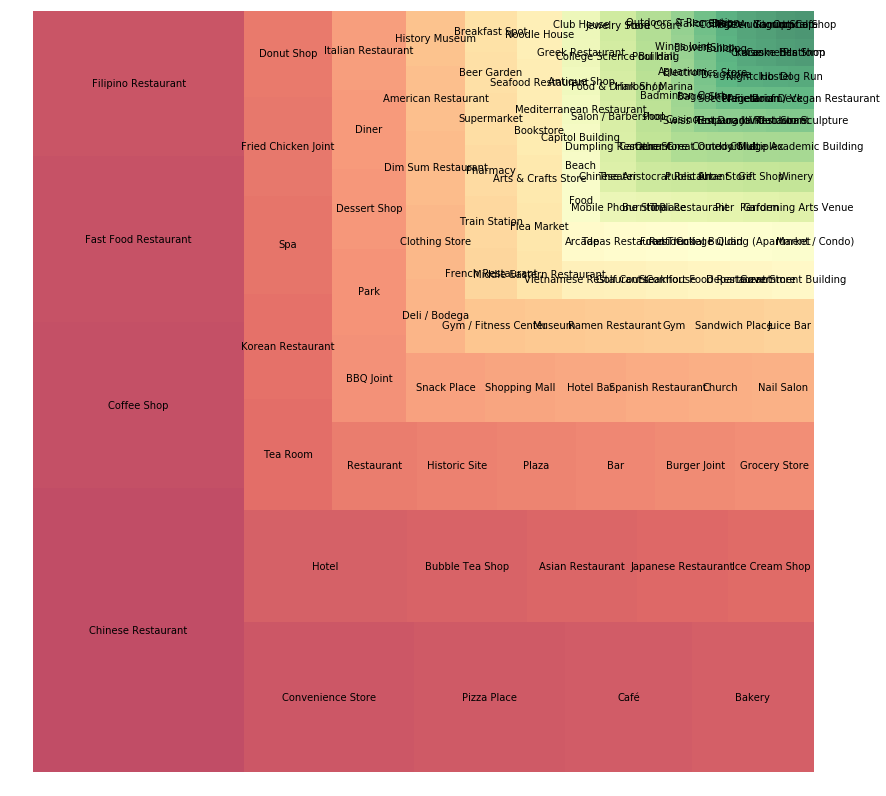

In [6]:
plt.figure(figsize=(14,14))
VenueCat = manila_venues['Venue_Cat'].value_counts()
sqr.plot(sizes=VenueCat.values,
         label=VenueCat.index,
         alpha=0.7,
         color=sns.color_palette("RdYlGn", VenueCat.shape[0])
        )
plt.axis('off')
plt.show() 

Text(0.5, 1.0, 'Top 20 Establishment Types in Manila')

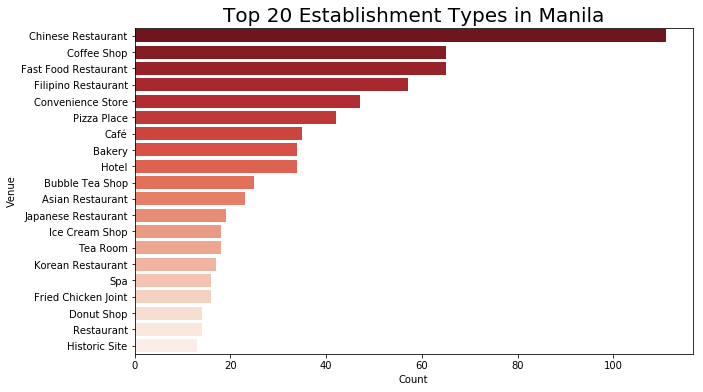

In [7]:
plt.figure(figsize=(10,6))
Top20_Venues = manila_venues['Venue_Cat'].value_counts().head(20)
Top20_Venues = pd.DataFrame({'Venue':Top20_Venues.index,
                            'Count':Top20_Venues.values
                           })
sns.barplot(y='Venue',
            x='Count',
            data=Top20_Venues,
            palette="Reds_r"
           )
plt.title('Top 20 Establishment Types in Manila',fontsize=20)

## Data Preparation <a id='DP'></a>
---

In [8]:
# one hot encoding
manila_df = pd.get_dummies(manila_venues[['Venue_Cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manila_df['District'] = manila_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [manila_df.columns[-1]] + list(manila_df.columns[:-1])
manila_df = manila_df[fixed_columns]

manila_districts = manila_venues['District'].value_counts()
manila_districts = pd.DataFrame({'District':manila_districts.index,
                                 'Establishment_Count':manila_districts.values})
manila_districts = pd.merge(manila_districts,df,how='left',on='District')

manila_df = manila_df.groupby('District').mean().reset_index()
manila_df = manila_df.sort_values('District')

# create columns according to number of top venues
columns = ['District']
num_top_venues=5
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = manila_df['District']

for ind in np.arange(manila_df.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manila_df.iloc[ind, :], num_top_venues)

manila_df = pd.merge(manila_districts,manila_df,how='left',on='District')

manila_clusters = pd.merge(manila_districts,neighborhoods_venues_sorted,how='left',on='District')

manila_df

(15, 139)


,District,Establishment_Count,Lon,Lat,American Restaurant,Antique Shop,Aquarium,Arcade,Arts & Crafts Store,Asian Restaurant,...,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Winery,Wings Joint
0,Malate,100,120.991529,14.568964,0.010000,0.000000,0.00,0.000000,0.000000,0.010000,...,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.000000
1,San Nicolas,100,120.969175,14.600518,0.000000,0.000000,0.00,0.000000,0.000000,0.030000,...,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.00,0.000000
2,Ermita,100,120.982242,14.579197,0.020000,0.000000,0.01,0.000000,0.000000,0.010000,...,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.000000
3,Santa Cruz,100,120.983426,14.615829,0.010000,0.000000,0.00,0.020000,0.000000,0.020000,...,0.000000,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,Binondo,100,120.974707,14.600899,0.000000,0.000000,0.00,0.000000,0.000000,0.030000,...,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.00,0.000000
5,Intramuros,99,120.975330,14.590586,0.000000,0.010101,0.00,0.000000,0.010101,0.030303,...,0.000000,0.000000,0.000000,0.010101,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,Sampaloc,97,120.996567,14.610265,0.020619,0.000000,0.00,0.010309,0.020619,0.020619,...,0.010309,0.020619,0.010309,0.000000,0.000000,0.000000,0.010309,0.000000,0.00,0.010309
7,Quiapo,93,120.987364,14.598139,0.000000,0.000000,0.00,0.000000,0.000000,0.010753,...,0.010753,0.064516,0.000000,0.010753,0.000000,0.010753,0.000000,0.000000,0.00,0.000000
8,San Andres,80,120.999547,14.573119,0.000000,0.000000,0.00,0.000000,0.000000,0.025000,...,0.000000,0.012500,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.00,0.000000
9,Paco,56,120.993492,14.584574,0.000000,0.000000,0.00,0.000000,0.000000,0.017857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017857,0.00,0.000000


# Modeling <a id='DM'></a>

Text(0.5, 1.0, 'Elbow curve (Optimal K = 4)')

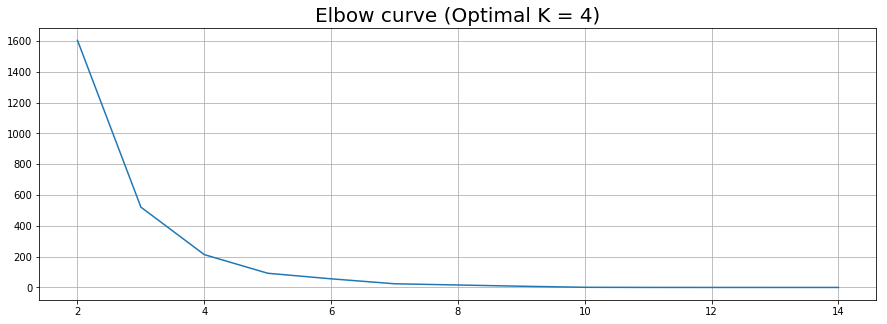

In [9]:
X = manila_df.drop('District', 1)
distorsions = []
for k in range(2, X.shape[0]):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, X.shape[0]), distorsions)
plt.grid(True)
plt.title('Elbow curve (Optimal K = 4)',fontsize=20)

In [10]:
Optimal_K=4
KM = KMeans(n_clusters=Optimal_K, random_state=0).fit(X)
manila_clusters['Cluster']=KM.labels_
manila_clusters

,District,Establishment_Count,Lon,Lat,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster
0,Malate,100,120.991529,14.568964,Hotel,Coffee Shop,Café,Chinese Restaurant,Korean Restaurant,1
1,San Nicolas,100,120.969175,14.600518,Chinese Restaurant,Fast Food Restaurant,Bakery,Pizza Place,Coffee Shop,1
2,Ermita,100,120.982242,14.579197,Coffee Shop,Hotel,Chinese Restaurant,Korean Restaurant,Japanese Restaurant,1
3,Santa Cruz,100,120.983426,14.615829,Filipino Restaurant,Coffee Shop,Fast Food Restaurant,Pizza Place,Bakery,1
4,Binondo,100,120.974707,14.600899,Chinese Restaurant,Coffee Shop,Bakery,Pizza Place,Deli / Bodega,1
5,Intramuros,99,120.975330,14.590586,Chinese Restaurant,Filipino Restaurant,Fast Food Restaurant,Historic Site,Coffee Shop,1
6,Sampaloc,97,120.996567,14.610265,Coffee Shop,Filipino Restaurant,Fast Food Restaurant,Pizza Place,Bubble Tea Shop,1
7,Quiapo,93,120.987364,14.598139,Chinese Restaurant,Filipino Restaurant,Bubble Tea Shop,Fast Food Restaurant,Coffee Shop,1
8,San Andres,80,120.999547,14.573119,Convenience Store,Fast Food Restaurant,Chinese Restaurant,Hotel,Coffee Shop,3
9,Paco,56,120.993492,14.584574,Convenience Store,Fast Food Restaurant,Grocery Store,Hotel,Filipino Restaurant,0


## Evaluation <a id='EV'></a>
---

In [11]:
address = 'Manila, Philippines'
geolocator = Nominatim(user_agent="geolocator")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_manila = folium.Map(location=[latitude, longitude],
                        zoom_start=13)
for (lat,
    lng,
    district,
    venue) in zip(manila_venues['Venue_Lat'],
                 manila_venues['Venue_Lon'],
                 manila_venues['District'],
                 manila_venues['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='grey',
        fill=False,
    ).add_to(map_manila)  
color = ['Red','Green','Blue','Orange']
for cluster,color in zip(range(0,4,1),color):
    cluster_df = manila_clusters[manila_clusters['Cluster']==cluster]
    for lat, lng, district in zip(cluster_df['Lat'],
                                  cluster_df['Lon'],
                                  cluster_df['District']):
        label = '{}, Manila'.format(district)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=8,
            popup=label,
            color=color,
            fill=False,
            fill_color=color,
            fill_opacity=0.9
        ).add_to(map_manila)  
map_manila

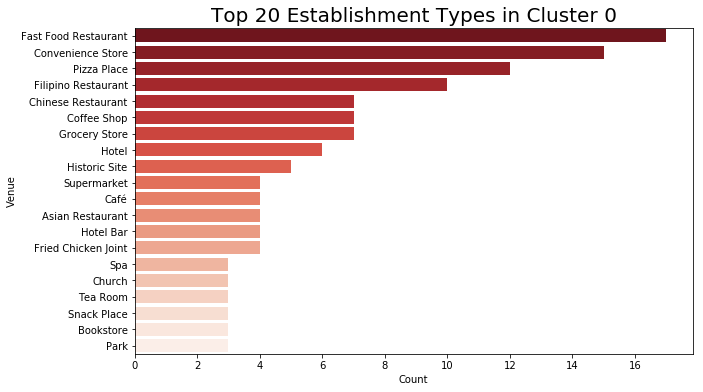

,District,Establishment_Count,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,Paco,56,Convenience Store,Fast Food Restaurant,Grocery Store,Hotel,Filipino Restaurant
10,Santa Mesa,52,Pizza Place,Chinese Restaurant,Convenience Store,Fried Chicken Joint,Fast Food Restaurant
11,Port Area,45,Historic Site,Hotel,Hotel Bar,Church,Fast Food Restaurant
12,San Miguel,41,Fast Food Restaurant,Pizza Place,Filipino Restaurant,Convenience Store,Tea Room


In [12]:
cluster_output(0,'Reds')

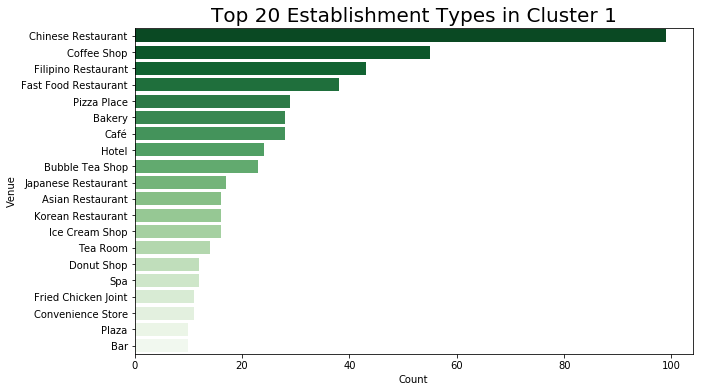

,District,Establishment_Count,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Malate,100,Hotel,Coffee Shop,Café,Chinese Restaurant,Korean Restaurant
1,San Nicolas,100,Chinese Restaurant,Fast Food Restaurant,Bakery,Pizza Place,Coffee Shop
2,Ermita,100,Coffee Shop,Hotel,Chinese Restaurant,Korean Restaurant,Japanese Restaurant
3,Santa Cruz,100,Filipino Restaurant,Coffee Shop,Fast Food Restaurant,Pizza Place,Bakery
4,Binondo,100,Chinese Restaurant,Coffee Shop,Bakery,Pizza Place,Deli / Bodega
5,Intramuros,99,Chinese Restaurant,Filipino Restaurant,Fast Food Restaurant,Historic Site,Coffee Shop
6,Sampaloc,97,Coffee Shop,Filipino Restaurant,Fast Food Restaurant,Pizza Place,Bubble Tea Shop
7,Quiapo,93,Chinese Restaurant,Filipino Restaurant,Bubble Tea Shop,Fast Food Restaurant,Coffee Shop


In [13]:
cluster_output(1,'Greens')

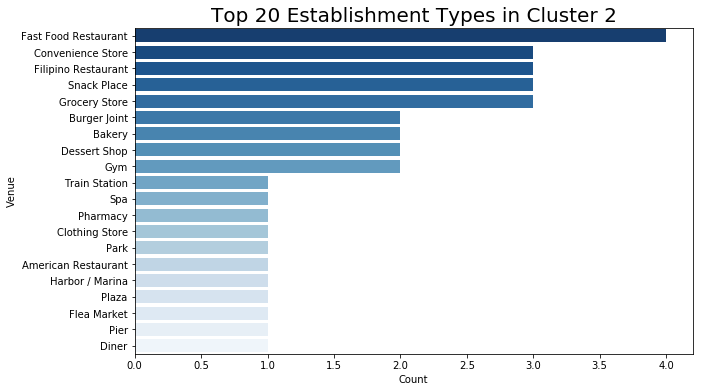

,District,Establishment_Count,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,Tondo,24,Fast Food Restaurant,Dessert Shop,Burger Joint,Snack Place,American Restaurant
14,Pandacan,16,Grocery Store,Filipino Restaurant,Convenience Store,Bakery,Gym


In [14]:
cluster_output(2,'Blues')

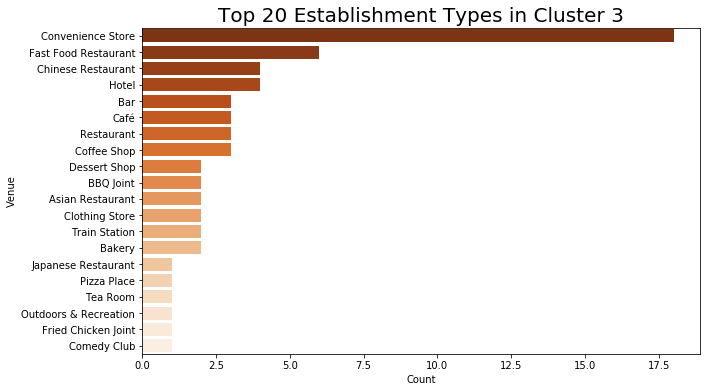

,District,Establishment_Count,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,San Andres,80,Convenience Store,Fast Food Restaurant,Chinese Restaurant,Hotel,Coffee Shop


In [15]:
cluster_output(3,'Oranges')

## Results <a id='RE'></a>
---
### Cluster 0 
Composed of the following Districts:
-  Paco
- Santa Mesa
- Port Area
- San Miguel

*Geographically, cluster 0 was near bodies of water.*
<br/>*San Miguel, Santa Mesa and Paco is along Pasig River.*
<br/>*While the Port Area is in front of Manila Bay.*

<br/>The **Top 5 establishments in cluster 0** were the following
1. Fast Food Restaurant
2. Convenience Store
3. Pizza Place
4. Filipino Restaurant
5. Grocery Store
---
### Cluster 1
Composed of the following Districts:
- Malate
- Ermita
- Binondo
- San Nicolas
- Santa Cruz
- Intramuros
- Sampaloc
- Quiapo

*Geographically, cluster 1 is the largest compare to other clusters.*
<br/>*Districts is along PNR rail tracks.*
<br/>*Most of the districts in this cluster is in zones with more establishments*

<br/>The **Top 5 establishments in cluster 1** were the following
1. Chinese Restaurant
2. Coffee Shop
3. Filipino Restaurant
4. Fast Food Restaurant
5. Pizza Place
---
### Cluster 2
Composed of the following Districts:
- Tondo
- Pandacan

*Geographically, cluster 2 is the also near a body of water.*
<br/>*There were less establishments surrounding the districts in this cluster*

<br/>The **Top 5 establishments in cluster 2** were the following
1. Fast Food Restaurant
2. Convenience Store
3. Grocery Store
4. Snack Place
5. Filipino Restaurant
---
### Cluster 3
Composed of the following:
- San Andres

*Geographically, cluster 3 is only composed of one district.*
<br/>*This cluster is not near a body of water relative to other clusters*
<br/>*It is near more establishments compare to Cluster 1 and 2*

<br/>The **Top 5 establishments in cluster 3** were the following:
1. Convenience Store
2. Fast Food Restaurant
3. Hotel
4. Chinese Restaurant
5. Coffee Shop